# Camera Calibration 


## Install libraries


In [12]:
%pip install opencv-python pupil-apriltags pillow-heif




[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import importlib


# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
# Fetch and import ES143 helper functions
# Using requests instead of wget (wget not available on macOS by default)
url = 'https://raw.githubusercontent.com/Harvard-CS283/pset-data/refs/heads/main/misc/es143_utils.py'
response = requests.get(url)
if response.status_code == 200:
    with open('es143_utils.py', 'w') as f:
        f.write(response.text)
    print("Successfully downloaded es143_utils.py")
else:
    print(f"Error downloading file: HTTP {response.status_code}")

from es143_utils import viz_board_calibration, detect_aprilboard, add_plotly_camera, add_plotly_plane


Successfully downloaded es143_utils.py


## Load AprilBoard related data


In [21]:
# Fetch and import 3D-coordinates for the four AprilBoards, as well as images of the boards!
# Using requests instead of wget (wget not available on macOS by default)
base_url = 'https://raw.githubusercontent.com/Harvard-CS283/pset-data/refs/heads/main/april/'
files_to_download = [
    'AprilBoardA.png',
    'AprilBoards2.pickle',
    'AprilBoardB.png',
    'AprilBoardC.png',
    'AprilBoardD.png'
]

for filename in files_to_download:
    url = base_url + filename
    response = requests.get(url)
    if response.status_code == 200:
        # For pickle files, write as binary; for images, write as binary too
        mode = 'wb' if filename.endswith('.pickle') or filename.endswith('.png') else 'w'
        with open(filename, mode) as f:
            f.write(response.content if mode == 'wb' else response.text)
        print(f"Downloaded {filename}")
    else:
        print(f"Error downloading {filename}: HTTP {response.status_code}")

with open('AprilBoards2.pickle', 'rb') as f:
    data = pickle.load(f)

at_board_a = data['at_board_a']
at_board_b = data['at_board_b']
at_board_c = data['at_board_c']
at_board_d = data['at_board_d']


Downloaded AprilBoardA.png
Downloaded AprilBoards2.pickle
Downloaded AprilBoardB.png
Downloaded AprilBoardC.png
Downloaded AprilBoardD.png


## Plot out the 4 AprilBoards for reference


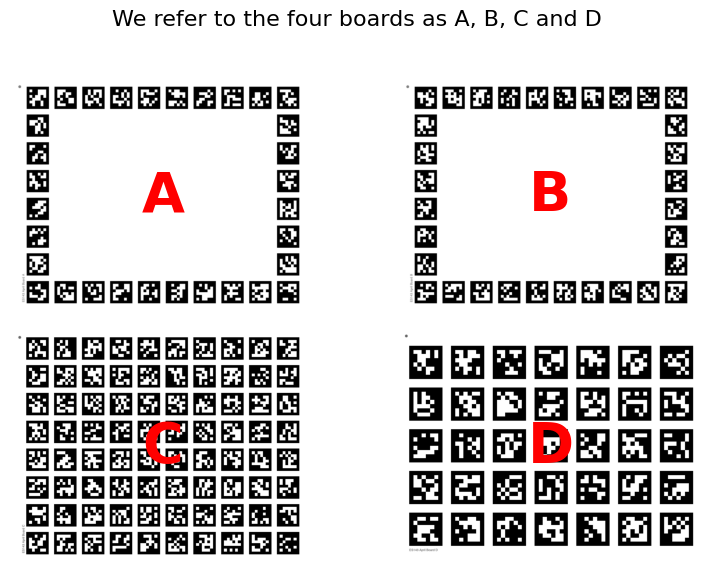

In [22]:
#@title Plot out the 4 AprilBoards for reference

# Load images
img_a = cv2.imread('AprilBoardA.png', cv2.IMREAD_GRAYSCALE)
img_b = cv2.imread('AprilBoardB.png', cv2.IMREAD_GRAYSCALE)
img_c = cv2.imread('AprilBoardC.png', cv2.IMREAD_GRAYSCALE)
img_d = cv2.imread('AprilBoardD.png', cv2.IMREAD_GRAYSCALE)

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()

# List of images and labels
boards = [(img_a, "A"), (img_b, "B"), (img_c, "C"), (img_d, "D")]

# Plot images with labels
for idx, (img, label) in enumerate(boards):
    ax = axes[idx]
    ax.imshow(img, cmap="gray")
    h, w = img.shape
    ax.text(w/2, h/2, label, color='red', fontsize=40, fontweight='bold', ha='center', va='center')
    ax.axis("off")

fig.suptitle("We refer to the four boards as A, B, C and D", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Detect fiducials


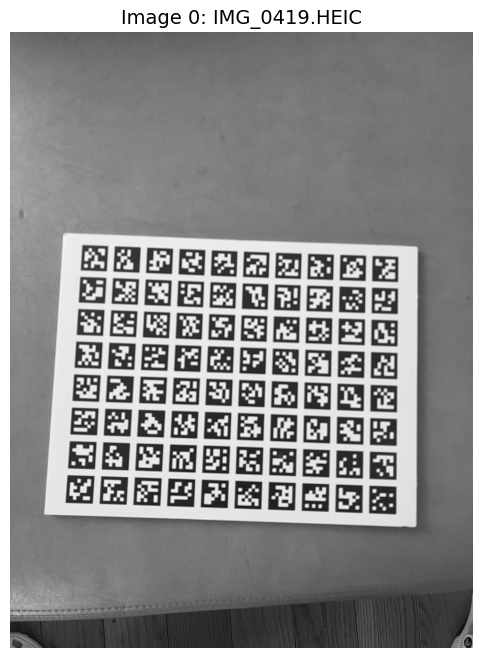

In [ ]:
#@title Display one image from camera_calib_raw

from camera_calib import read_image_heic

# Get list of images in camera_calib_raw
calib_images = sorted(glob.glob('./camera_calib_raw/*.HEIC'))

# Select which image to display (change index to see different images)
image_index = 0

if calib_images:
    # Read the image
    img = read_image_heic(calib_images[image_index])
    
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {image_index}: {calib_images[image_index].split("/")[-1]}', fontsize=14)
    plt.show()
else:
    print("No images found in camera_calib_raw folder")

20 images:
0 ./camera_calib_raw/IMG_0419.HEIC: 78 imgpts, 78 objpts
1 ./camera_calib_raw/IMG_0420.HEIC: 80 imgpts, 80 objpts
2 ./camera_calib_raw/IMG_0421.HEIC: 80 imgpts, 80 objpts
3 ./camera_calib_raw/IMG_0422.HEIC: 80 imgpts, 80 objpts
4 ./camera_calib_raw/IMG_0423.HEIC: 80 imgpts, 80 objpts
5 ./camera_calib_raw/IMG_0424.HEIC: 80 imgpts, 80 objpts
6 ./camera_calib_raw/IMG_0425.HEIC: 80 imgpts, 80 objpts
7 ./camera_calib_raw/IMG_0426.HEIC: 80 imgpts, 80 objpts
8 ./camera_calib_raw/IMG_0427.HEIC: 80 imgpts, 80 objpts
9 ./camera_calib_raw/IMG_0428.HEIC: 80 imgpts, 80 objpts
10 ./camera_calib_raw/IMG_0429.HEIC: 80 imgpts, 80 objpts
11 ./camera_calib_raw/IMG_0430.HEIC: 80 imgpts, 80 objpts
12 ./camera_calib_raw/IMG_0431.HEIC: 77 imgpts, 77 objpts
13 ./camera_calib_raw/IMG_0432.HEIC: 80 imgpts, 80 objpts
14 ./camera_calib_raw/IMG_0433.HEIC: 80 imgpts, 80 objpts
15 ./camera_calib_raw/IMG_0434.HEIC: 80 imgpts, 80 objpts
16 ./camera_calib_raw/IMG_0435.HEIC: 80 imgpts, 80 objpts
17 ./camera_c

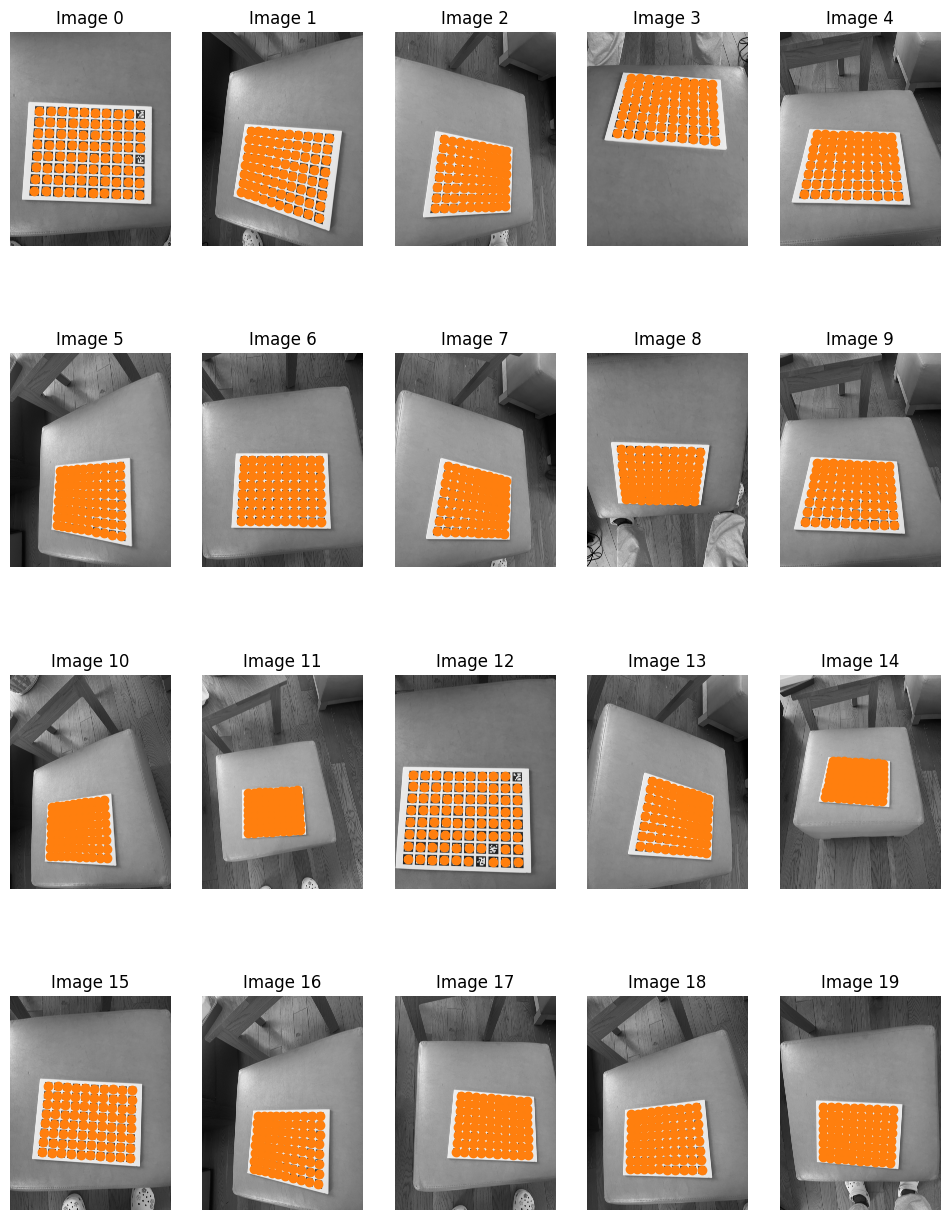

In [33]:
#@title Detect fiducials

N = 30  # only use images with at least N detected objects for calibration

total_valid = 0

# Get list of images in camera_calib_raw (same indexing as display cell)
calib_images = sorted(glob.glob('./camera_calib_raw/*.HEIC'))

# Uncomment one of the following two lines to indicate which AprilBoard is being used for calibration
BOARD = at_board_c

###### BEGIN CALIBRATION SCRIPT

# Import helper function for reading HEIC files
from camera_calib import read_image_heic

# set up april tag detector
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

# exit if no images are found or if BOARD is unrecognized
assert calib_images, "no calibration images found in camera_calib_raw folder"

# else continue
print("{} images:".format(len(calib_images)))

# initialize 3D object points and 2D image points
calObjPoints = []
calImgPoints = []
valid_image_files = []  # Track which images were actually used for calibration

# define the number of columns for the plot, then calculate number of rows
num_plot_cols = 5
num_plot_rows = (len(calib_images) + num_plot_cols - 1) // num_plot_cols

# create the figure and axes; flatten the axes array for convenience
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
axs = axs.flatten()

# loop through the images
for count, fname in enumerate(calib_images):
    # read image and convert to grayscale if necessary
    orig = read_image_heic(fname)
    if orig is None:
        print(f"Warning: Could not read {fname}, skipping...")
        continue
        
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    else:
        img = orig

    # show image
    axs[count].imshow(img / 255.0, cmap="gray")
    axs[count].set_axis_off()
    axs[count].set_title("Image {}".format(count))

    # detect apriltags and report number of detections
    imgpoints, objpoints, tagIDs = detect_aprilboard(img, BOARD, at_detector)
    #print("{} {}: {} imgpts, {} objpts".format(count, fname, len(imgpoints),len(objpoints)))
    print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

    # append detections if some are found
    if len(imgpoints) >= N and len(objpoints) >= N:
        total_valid += 1
        # display detected tag centers
        axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')
        # append points detected in all images, (there is only one image now)
        calObjPoints.append(objpoints.astype('float32'))
        calImgPoints.append(imgpoints.astype('float32'))
        valid_image_files.append(fname)  # Track which image was used

plt.show()


## Calibrate camera


In [34]:
#@title Calibrate camera

# calibrate the camera
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPoints,
    calImgPoints,
    img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
    None,         # no initial guess for the remaining entries of calMatrix
    None,         # initial guesses for distortion coefficients are all 0
    flags = None) # default contstraints (see documentation)

# Print output, including reprojection error, which is the root mean square (RMS)
#   re-projection error in pixels. If this value is much greater than 1, it is
#   likely to be a bad calibration.  Examine the images and detections, and the
#   options given to cv2.calibrateCamera() to figure out what went wrong.
np.set_printoptions(precision=5, suppress=True)
print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)

np.set_printoptions(precision=2, suppress=True)
print('Intrinsic camera matrix:\n', calMatrix)
print('Total images used for calibration: ', total_valid)

RMSE of reprojected points: 0.901761054133646
Distortion coefficients: [[ 0.12992 -0.5704   0.00134 -0.001    0.81412]]
Intrinsic camera matrix:
 [[3011.18    0.   1535.04]
 [   0.   3013.28 2040.55]
 [   0.      0.      1.  ]]
Total images used for calibration:  20


## Display the projected points in one of the images


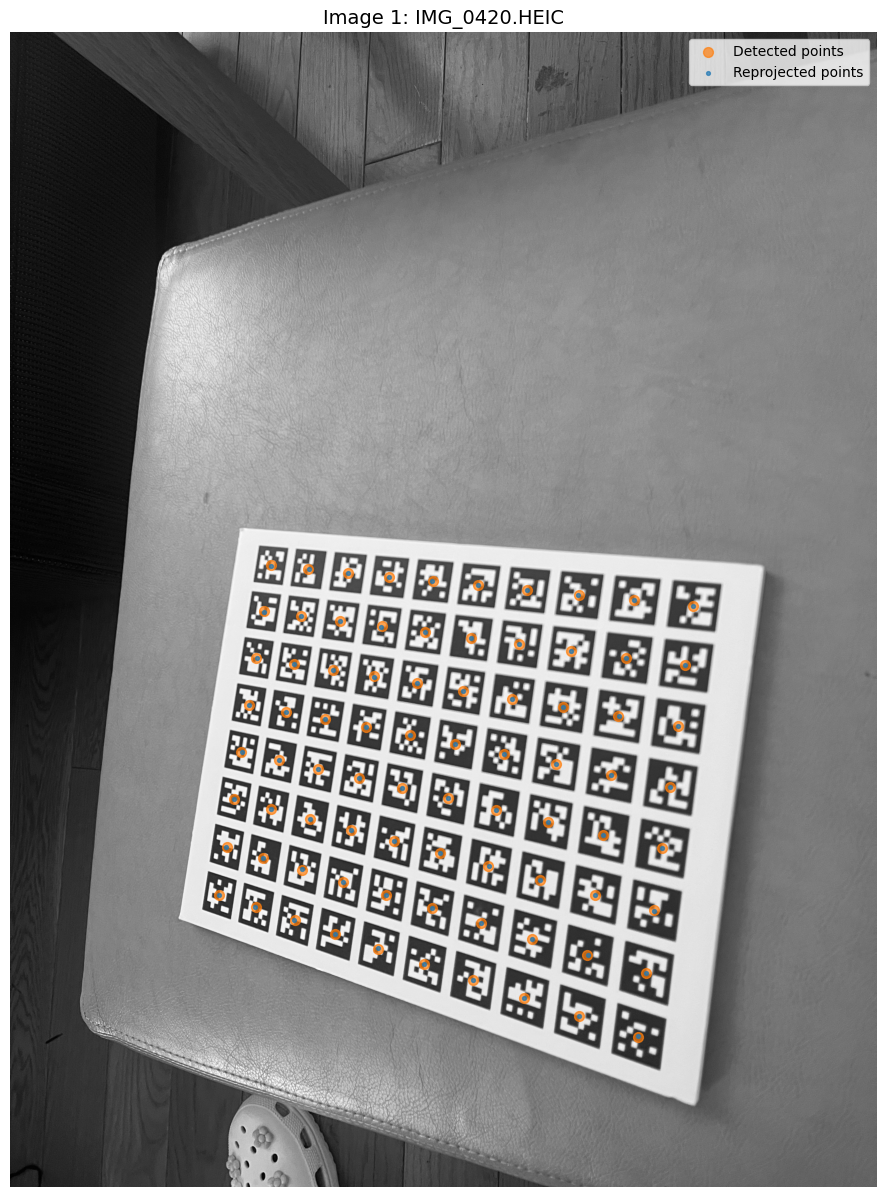

In [36]:
#@title Display the projected points in one of the images

# change this to select which calibration image to display
# IMNUM indexes into the valid images (only those used for calibration)
IMNUM = 1

# Make sure IMNUM is within valid range
assert 0 <= IMNUM < len(calImgPoints), f"IMNUM must be between 0 and {len(calImgPoints)-1}"

# Use valid_image_files to get the correct image file
# This ensures we're displaying the same image that was used for calibration at index IMNUM
image_file = valid_image_files[IMNUM]

# read image and convert to grayscale if necessary
# Use read_image_heic to handle HEIC files
from camera_calib import read_image_heic
orig = read_image_heic(image_file)
if orig is None:
    raise ValueError(f"Could not read image: {image_file}")

if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
else:
    img = orig

# create figure, show image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img / 255.0, cmap="gray")
ax.set_axis_off()
ax.set_title(f"Image {IMNUM}: {image_file.split('/')[-1]}", fontsize=14)

# show detected points (in orange)
ax.scatter(calImgPoints[IMNUM][:,0], calImgPoints[IMNUM][:,1], marker='o', color='#ff7f0e', s=50, label='Detected points', alpha=0.7)

# compute reprojections
imgpoints2, _ = cv2.projectPoints(calObjPoints[IMNUM],
                                  calRotations[IMNUM],
                                  calTranslations[IMNUM],
                                  calMatrix, distCoeffs)
imgpoints2 = np.squeeze(imgpoints2)  # eliminate the leading single dimension

# show reprojected points (in blue)
ax.scatter(imgpoints2[:,0], imgpoints2[:,1], marker='.', color='#1f77b4', s=30, label='Reprojected points', alpha=0.7)
ax.legend()
plt.show()